# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
import math
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

## Откройте и изучите файл

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head(20)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
print(df[df['is_ultra'] == 0])
df[df['is_ultra'] == 1]

      calls  minutes  messages   mb_used  is_ultra
0      40.0   311.90      83.0  19915.42         0
1      85.0   516.75      56.0  22696.96         0
2      77.0   467.66      86.0  21060.45         0
4      66.0   418.74       1.0  14502.75         0
5      58.0   344.56      21.0  15823.37         0
...     ...      ...       ...       ...       ...
3206   76.0   586.51      54.0  14345.74         0
3207   17.0    92.39       2.0   4299.25         0
3210   25.0   190.36       0.0   3275.61         0
3211   97.0   634.44      70.0  13974.06         0
3212   64.0   462.32      90.0  31239.78         0

[2229 rows x 5 columns]


,calls,minutes,messages,mb_used,is_ultra
3,106.0,745.53,81.0,8437.39,1
6,57.0,431.64,20.0,3738.90,1
8,7.0,43.39,3.0,2538.67,1
10,82.0,560.51,20.0,9619.53,1
14,108.0,587.90,0.0,14406.50,1
...,...,...,...,...,...
3201,56.0,419.42,59.0,5177.62,1
3203,53.0,390.39,85.0,30550.30,1
3208,164.0,1016.98,71.0,17787.52,1
3209,122.0,910.98,20.0,35124.90,1


In [5]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Приведем тип данных messages и calls к целочисленным

In [6]:
df['messages'] = df['messages'].astype(int)
df['calls'] = df['calls'].astype(int)

### Вывод
- Данные в предобработке не нуждаются
- Пропуски в данных отсутствуют
- Изменен тип данных в тех столбцах, где это имеет место быть
- Большинство пользователей предпочитают тариф "Смарт"

## Разбейте данные на выборки

Разобьем данные на три выборки для обучения и проверки модели:
- Обучающая (df_train)
- Валидационная (df_valid)
- Тестовая (df_test)

Соотношение выборок будет 3:1:1


In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test_valid = train_test_split(df, test_size = 0.40, random_state = 12345)
df_valid, df_test = train_test_split(df_test_valid, test_size = 0.50, random_state = 12345)

print(df_train.shape)
print(df_valid.shape)
df_test.shape

(1928, 5)
(643, 5)


(643, 5)

### Вывод
Созданы три выборки для дальнейшей работы

## Исследуйте модели

В данной части выполним следующие пункты:
- Подготовим данные для модели
- Рассмотрим различные модели
- Подберем оптимальные гиперпараметры модели, чтобы увеличить accuracy (не менее 0.75)

In [8]:
# Подготовка датафрейма

features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

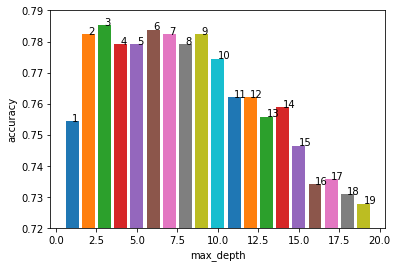

In [9]:
# Дерево принятия решений
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

for depth in range(1,20):
    model = DecisionTreeClassifier(random_state = 12345,
                                   max_depth = depth,
                                   )
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    plt.bar(depth,accuracy)
    plt.ylim(0.72,0.79)
    plt.text(depth, accuracy, depth)
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
plt.show()

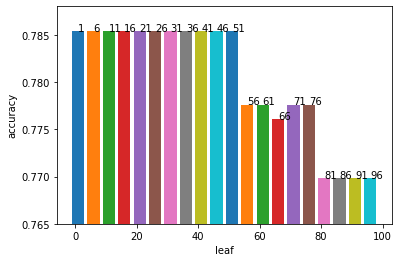

In [29]:
#Переберем также значения min_samples_leaf с шагом 5, чтобы выбрать лучший. 
#Выберем 3 варианта max_depth показавшие максимальное значение accuracy (3,6,9)

for leaf in range(1, 100, 5):
    model = DecisionTreeClassifier(random_state = 12345,
                                   max_depth = 3,
                                   min_samples_leaf = leaf
                                   )
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    plt.bar(leaf,accuracy,width=4)
    plt.ylim(0.765,0.788)
    plt.text(leaf, accuracy, leaf)
    plt.xlabel('leaf')
    plt.ylabel('accuracy')

plt.show()

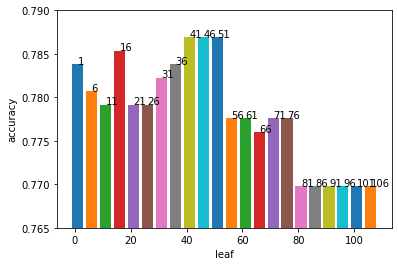

In [59]:
for leaf in range(1, 110, 5):
    model = DecisionTreeClassifier(random_state = 12345,
                                   max_depth = 6,
                                   min_samples_leaf = leaf
                                   )
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    plt.bar(leaf,accuracy, width=4)
    plt.ylim(0.765,0.79)
    plt.text(leaf, accuracy, leaf)
    plt.xlabel('leaf')
    plt.ylabel('accuracy')

plt.show()

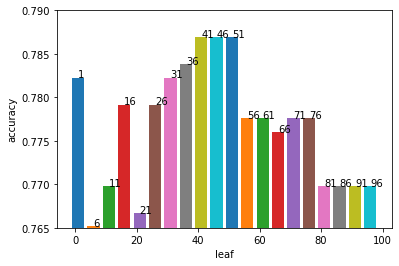

In [40]:
for leaf in range(1, 100, 5):
    model = DecisionTreeClassifier(random_state = 12345,
                                   max_depth = 9,
                                   min_samples_leaf = leaf
                                   )
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    plt.bar(leaf,accuracy,width=4)
    plt.ylim(0.765,0.79)
    plt.text(leaf, accuracy, leaf)
    plt.xlabel('leaf')
    plt.ylabel('accuracy')

plt.show()

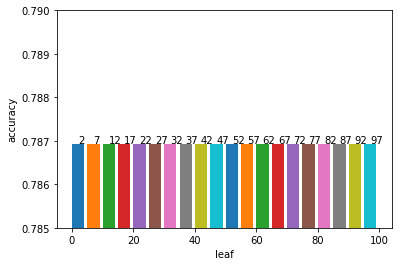

In [52]:
#Аналогично поступим с min_samples_split при max_depth=6 и min_samples_leaf=50 как самое высокое значение 

for split in range(2, 100, 5):
    model = DecisionTreeClassifier(random_state = 12345,
                                   max_depth = 6,
                                   min_samples_leaf = 50,
                                   min_samples_split = split
                                   )
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    plt.bar(split,accuracy,width=4)
    plt.ylim(0.785,0.79)
    plt.text(split, accuracy, split)
    plt.xlabel('leaf')
    plt.ylabel('accuracy')

plt.show()

In [68]:
model = DecisionTreeClassifier(random_state = 12345,
                               max_depth = 6,
                               min_samples_leaf = 50
                               )
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print(accuracy)

0.7869362363919129


Наибольшее значение accuracy (0.7869) показывает модель с max_depth = 6 , min_samples_split = 50,  

Будем использовать данные значения гиперпараметров для случайного леса

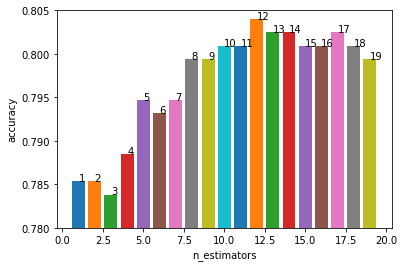

In [69]:
# Случайный лес
from sklearn.ensemble import RandomForestClassifier

for est in range(1,20):
    model = RandomForestClassifier(random_state = 12345, 
                                   max_depth = 6, 
                                   n_estimators = est
                                  )
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    plt.bar(est,accuracy)
    plt.ylim(0.78,0.805)
    plt.text(est, accuracy, est)
    plt.xlabel('n_estimators')
    plt.ylabel('accuracy')
plt.show()
    

In [73]:
#Проверим гиперпараметр criterion='entropy' с значением n_estimators=12

model = RandomForestClassifier(random_state = 12345, 
                                   max_depth = 6, 
                                   n_estimators = est,
                                   criterion='entropy'
                                  )
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print(accuracy)

0.8009331259720062


Наибольшее значение accuracy (0.8040) показывает модель с n_estimators = 12 и max_depth = 6

Интересно, что параметры min_samples_leaf и min_samples_split только снижали значение accuracy, поэтому было принято решение их не изменять

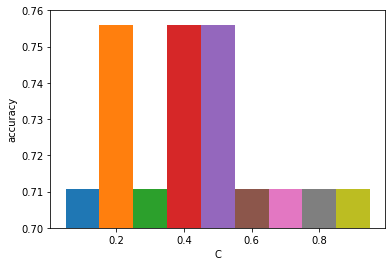

In [86]:
# Логистическая регрессия
from sklearn.linear_model import LogisticRegression

for strength in np.arange(0.1,1,0.1):
    model = LogisticRegression(random_state=12345, C=strength)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)

    plt.bar(strength,accuracy,width=0.1)
    plt.ylim(0.7,0.76)
    plt.xlabel('C')
    plt.ylabel('accuracy')
plt.show()


model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)


In [87]:
model = LogisticRegression(random_state=12345, C=0.5)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print(accuracy)

0.7558320373250389


Результаты оказались ниже, чем у других моделей (0.7558)

### Вывод
- Были подготовлены данный для обучения
- Обучили модель тремя разными способами и получили соответствующие максимальные значения:
    - Дерево принятия решения 79% Accuracy с гиперпараметрами max_depth = 6 , min_samples_split = 100 , min_samples_leaf = 5
    - Случайный лес 80% Accuracy с гиперпараметром max_depth = 6, n_estimators = 12 остальные остались неизменны, так как при подборе других значений уменьшалась accuracy
    - Линейная регрессия 71% Accuracy
    
Для следующей главы будем использовать случайный лес

## Проверьте модель на тестовой выборке

In [88]:
# Подготовим данные для теста и построим модель случайного леса

features_test = df_test.drop(['is_ultra'], axis = 1)
target_test = df_test['is_ultra']

model = RandomForestClassifier(random_state = 12345,
                               n_estimators = 12,
                               max_depth = 6
                              )
model.fit(features_train, target_train)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)

print('{:.4f}'.format(accuracy))

0.7947


### Вывод

Мы проверили модель на тестовой выборке и получили результат устраивающий нас по требованиям (Accuracy не меньше 0.75)

Следовательно для компании Мегалайн предлагаем использовать модель случайного леса с параметрами n_estimators = 12, max_depth = 6, для того, чтобы предсказывать какой тариф предлагать клиентам со старыми тарифами

## (бонус) Проверьте модели на адекватность

Для этого проведем 2 теста:
- Подбрасывание монетки
- Значения являются одинаковыми(просто предлагать всем тариф Ultra или Smart)

In [18]:
import random

random_predictions = np.random.randint(low = 0, high = 2, size = 643) 

ultra_only = np.random.randint(low = 1, high = 2, size = 643)

accuracy_rand = accuracy_score(target_test, random_predictions)
accuracy_ultra = accuracy_score(target_test, ultra_only)

print('Правильные ответы (рандом):','{:.4f}'.format(accuracy_rand))
print('Правильные ответы (только ультра):','{:.4f}'.format(accuracy_ultra))
print('Правильные ответы (только смарт):', 1 - accuracy_ultra)

Правильные ответы (рандом): 0.4961
Правильные ответы (только ультра): 0.3157
Правильные ответы (только смарт): 0.6842923794712286


Как видно, accuracy намного ниже чем у нашей модели, значит наша модель является адекватной. Так же стоит отметить, что значения 2 и 3 варианта напрямую зависят от соотношения тарифов(см. п. 1)